Probelm tanımı: rakamgoruntuleri olsuturma \
cosuzm: gan modeli insaa edelim\
sonuc: generator rakam goruntusu olusturacak\
veriseti: mnist

veri seti içeriye aktarama ve preorocessing: normalization, boyutlandırma ayarlar

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LeakyReLU #! onemli
from tensorflow.keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, BatchNormalization
from tensorflow.keras.optimizers import Adam

from tqdm import tqdm # for dongusu sayaci
import warnings
warnings.filterwarnings('ignore')

In [2]:
(x_train, _), (_, _) = mnist.load_data() #sadece x_traini kullancağimdan diğerilerini "_" yaptik
x_train = x_train /255.0
#28x28 -> 28,28,1
x_train = np.expand_dims(x_train, axis=-1)

create discirminator ve generator

In [3]:
#discriminator modeli tanıma: gercek ve sahte goruntuyu ayıracak
def build_discriminator():
    model = Sequential()
    #feature extracciton
    #64 filter (3x3)
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same", input_shape = (28,28,1)))
    model.add(LeakyReLU(alpha = 0.2))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(LeakyReLU(alpha = 0.2))
    #classificatin: fake mi? real mi?
    model.add(Flatten()) # goruntuyu tek boyutlu vektore donsuturyuor
    model.add(Dense(1,activation="sigmoid")) #output layer
    #compile
    model.compile(loss = "binary_crossentropy", optimizer = Adam(0.0002, 0.5), metrics = ["accuracy"] )
    return model

In [4]:
build_discriminator().summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        640       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         73856     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense (Dense)               (None, 1)                 6273      
                                                                 
Total params: 80769 (315.50 KB)
Trainable params: 80769 

In [5]:
zdim = 100

In [10]:
#Generator Modei tanimla: sahte goruntu insaa edicek
def build_generator():
    model = Sequential()
    # Gürültü vektöründen yüksek boyutlu bir uzaya dönüşüm
    model.add(Dense(7*7*128, input_dim = zdim)) # gurultu vektorunden yuksek boyutlu uzaya donusum
    model.add(LeakyReLU(alpha= 0.2))
    model.add(Reshape((7,7,128))) # 3 boyurtlu matrise cevirdik
    model.add(BatchNormalization(momentum=0.8)) # Normalizasyon işlemi

    # İlk Conv2DTranspose katmanı ile boyutları artır
    model.add(Conv2DTranspose(64, kernel_size=3, strides=2, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))  # Normalizasyon
    
    # Son katman: 28x28 boyutunda bir görüntü üretmek
    model.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding="same", activation="tanh"))

    return model

In [11]:
build_generator().summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 6272)              633472    
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 6272)              0         
                                                                 
 reshape_2 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 batch_normalization_6 (Bat  (None, 7, 7, 128)         512       
 chNormalization)                                                
                                                                 
 conv2d_transpose_6 (Conv2D  (None, 14, 14, 64)        73792     
 Transpose)                                                      
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 14, 14, 64)       

create and train gan model gan = discrimator + generator

In [12]:
# gan modeli olusturuyuruz
def build_gan(generator, discriminator):
    discriminator.trainable = False # discriminator ga nicinde egitilmez
    model = Sequential()
    model.add(generator) # gan yapısına genertor ekledik
    model.add(discriminator) # gan yapısına discriminator ekledik
    model.compile(loss = "binary_crossentropy", optimizer = Adam(0.0002, 0.5))

    return model

In [13]:
discriminator = build_discriminator()
generator = build_generator()
gan = build_gan(generator, discriminator)
gan.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_7 (Sequential)   (None, 28, 28, 1)         708609    
                                                                 
 sequential_6 (Sequential)   (None, 1)                 80769     
                                                                 
Total params: 789378 (3.01 MB)
Trainable params: 708225 (2.70 MB)
Non-trainable params: 81153 (317.00 KB)
_________________________________________________________________


In [14]:
print(f"Generator: {generator}")
print(f"Discriminator: {discriminator}")
print(f"GAN: {gan}")

Generator: <keras.src.engine.sequential.Sequential object at 0x000001A086562CE0>
Discriminator: <keras.src.engine.sequential.Sequential object at 0x000001A086563820>
GAN: <keras.src.engine.sequential.Sequential object at 0x000001A086823CA0>


In [15]:
print(hasattr(discriminator, "train_on_batch"))  # True olmalı
print(hasattr(gan, "train_on_batch"))  # True olmalı

True
True


In [16]:
#gan training

epochs = 50
batch_size = 64
half_batch = batch_size//2

#egitim dongusu
for epoch in tqdm(range(epochs), desc="Training Process"): #tkdm ilerleme cubugu

    # fake veriler ve gercek verielri ile discirminator egitimi

    # gercek verielr ile discriminator egitimi
    idx = np.random.randint(0, x_train.shape[0], half_batch) # x_train iceridsinde nrastegeke 32 adet, half_batch asaysıı kadar veri sectik

    real_images = x_train[idx] # gercek goruntuler
    real_labels = np.ones((half_batch, 1)) # gercek goruntu etiketi = 1
    
    # Fake verielri(generatorun urettigi) kullanrak discrimator egitimi
    noise = np.random.normal(0, 1, (half_batch, zdim)) # gurutltu vektoru
    fake_images = generator.predict(noise, verbose = 0) # goruntu ile uretilen goruntu
    fake_labels = np.zeros((half_batch, 1)) # sahte goruntu etiketleri = 0

    # update discriminator
    d_loss_real =  discriminator.train_on_batch(real_images, real_labels) # gercek veriler ile loss(kayıp) hesabı 
    d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels) # fake gorutnuler ile loss(kayıp) hesaplama
    d_loss = np.add(d_loss_fake, d_loss_real) * 0.5 # ortlama kayıp

    # gan egitimi
    noise = np.random.normal(0,1, (batch_size, zdim)) # gurutlu olsutur
    valid_y = np.ones ((batch_size, 1))
    g_loss = gan.train_on_batch(noise, valid_y) # gan'ın icinde buluanan generatorun egitimi

    if epoch % 100 == 0:
        print(f"{epoch}/{epochs} d_loss: {d_loss[0]}, g_loss")


Training Process:   2%|▏         | 1/50 [00:04<03:44,  4.58s/it]

0/50 d_loss: 0.6968149840831757, g_loss


Training Process: 100%|██████████| 50/50 [00:14<00:00,  3.40it/s]


test and evulation: gorsel ve metrik

In [17]:
#uretilen gorntulerin gorsellestirilmesi

def plot_generatd_images(generator, examples = 10, dim = (1,10)):
    noise = np.random.normal(0,1, (examples, zdim)) # gurultu vektorleri
    gen_images = generator.predict(noise, verbose = 0) # uretilen goruntuelrimiz
    gen_images = 0.5 * gen_images + 0.5

    plt.figure(figsize= (10,1))
    for i in range(gen_images.shape[0]):
        plt.subplot(dim[0],dim[1], i+1)
        plt.imshow(gen_images[i, :, :, 0], cmap="gray") # gorutnuyu gri tonlanmasında goster
        plt.axis("off")
    plt.tight_layout()
    plt.show()

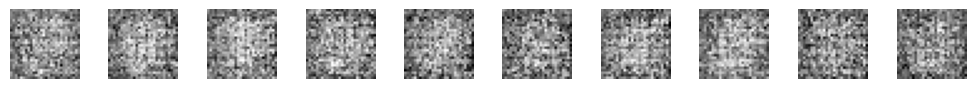

In [18]:
plot_generatd_images(generator)